## Setup

In [2]:
import os
import sys

import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
import matplotlib.pyplot as plt

In [3]:
# Helper function to open a pickle streamfunction and format it as an xarray dataset
def read_streamfunction(strf_path, timesteps, invert_depths=True, Z=None):
    with open(strf_path, 'rb') as f:
        strf = pickle.load(f).astype(np.float64)

    print(strf.shape)
    if Z is None:
        ECCO_GRID = xr.open_dataset(paths.geom_fp)
        Z = ECCO_GRID.coords['Z'].data

    if invert_depths is True:
        strf = strf[::-1] #Invert the depth values
        
    if len(strf.shape) == 2: 
        strf = np.transpose(strf, (1,0)) 
    else:
        strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
        strf = np.transpose(strf, (2,0,1)).squeeze()
    strf = xr.Dataset(
            data_vars = {'moc' : (["time", "k"], strf)}, 
            coords = {'time' : timesteps,  'k': np.arange(strf.shape[1])}
            )
    
    strf = strf.assign_coords(Z=('k', Z))
    return strf

In [4]:
# Helper function to open a pickle moc strength file and format is as an xarray dataset
def read_moc_strength_dataset(moc_path, time_steps, invert_depths=True):
    with open(moc_path, 'rb') as f:
        moc = pickle.load(f).astype(np.float64)
    
    if invert_depths is True:
        moc = moc[::-1]
        
    moc = xr.Dataset(
        data_vars={'moc': (["time"], moc)},
        coords={'time': time_steps}
    )
    return moc

In [5]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    print(max_index)
    return PSI.isel(k=max_index)

In [6]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## Experiment variables

In [7]:
data_home = paths.LOCAL_DIR
lat = -60

ECCO_GRID = xr.open_dataset(paths.geom_fp)
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))

## Compare depth versus density maximal moc strength at a particular latitude

In [8]:
lat = -30

In [9]:
# We plot the streamfunction in depth space and use the moc in density space 
strf_depth_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_sf_depth.pickle"
moc_dens_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_moc_density.pickle"

In [10]:
# Read in the maximal moc strength and the streamfunction
moc_dens = read_moc_strength_dataset(moc_dens_path, inputs.time)
strf = read_streamfunction(strf_depth_path, inputs.time)

# Calculate the depth level at which the abyssal cell is in depth space
strf_comparison = strf.copy(deep=True)
strf_comparison['moc'].loc[dict(k=slice(0,20))] = 1e6
k_index = strf_comparison['moc'].mean("time").argmin(dim="k")
Z_depth = ECCO_GRID.coords['Z'].data[k_index]
print(Z_depth)

# Determine for the moc strength in density space at each timestep to which depth it corresponds
difference = abs(strf_comparison - moc_dens.broadcast_like(strf_comparison))
min_diff_index = difference.argmin(dim='k')
closest_depths = strf.Z.isel(k=min_diff_index.moc.values)
closest_depths = closest_depths.rename({'k': 'time'})

(50, 312)
-3581.25


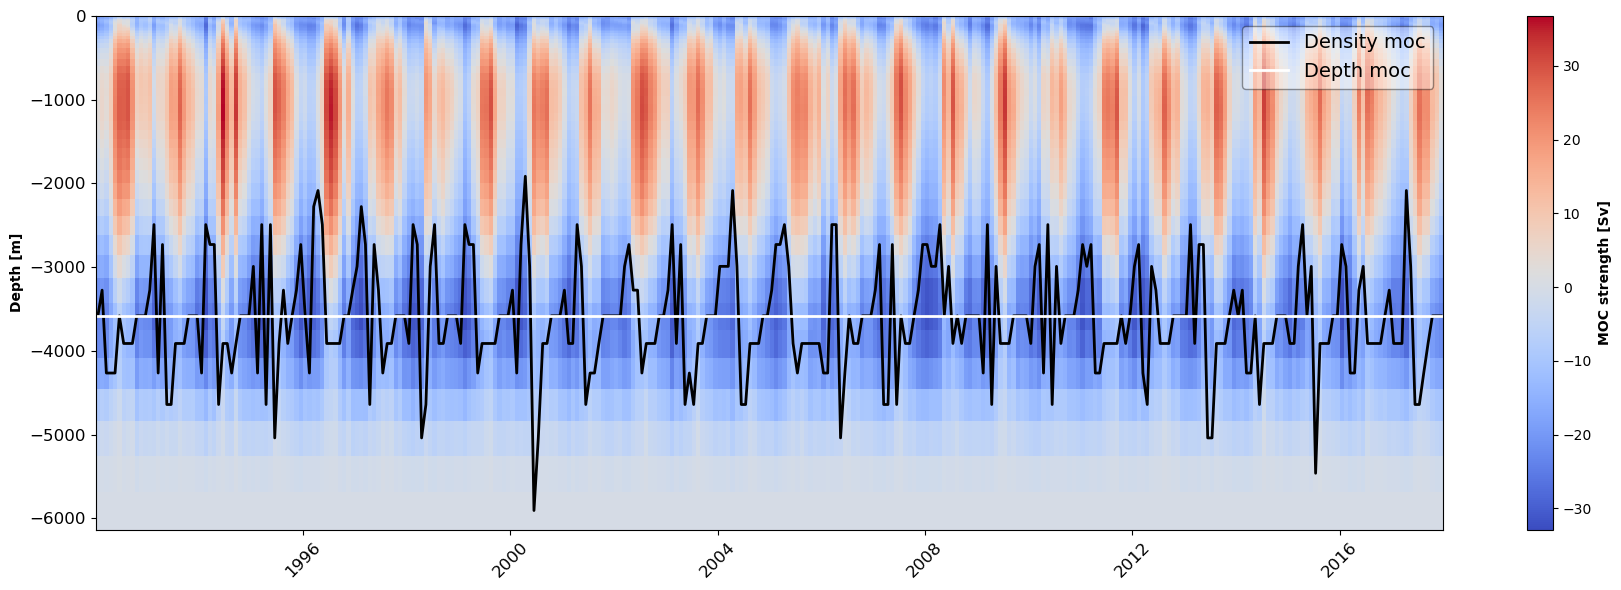

In [11]:
# Plot the streamfunction in depth space with the corresponding density -> depth levels
stf_ds = strf.squeeze()

from matplotlib import colors
norm=colors.TwoSlopeNorm(vcenter=0.)

fig = plt.figure(figsize=(18, 6))
plt.subplot(1, 1, 1) 
time_edge_extrap = np.hstack((
    stf_ds["time"].values[0] - (0.5 * np.diff(stf_ds["time"].values[0:2])),
    stf_ds["time"].values[:-1] + (0.5 * np.diff(stf_ds["time"].values)),
    stf_ds["time"].values[-1] + (0.5 * np.diff(stf_ds["time"].values[-2:])),
    ))
Z_edge_extrap = np.hstack((
    np.array([0]),
    stf_ds["Z"].values[:-1] + (0.5 * np.diff(stf_ds["Z"].values)),
    np.array([-6134.5]),
    ))
pcm = plt.pcolormesh(time_edge_extrap, Z_edge_extrap, stf_ds['moc'].T, shading='auto', cmap='coolwarm')
plt.ylabel("Depth [m]", weight="bold")
plt.tick_params(labelsize=12)
plt.xticks(rotation=45)
cb = plt.colorbar(pcm)
cb.set_label("MOC strength [Sv]", weight="bold")

plt.plot(stf_ds["time"].values, closest_depths, color='black', linestyle='-', linewidth=2.0, label='Density moc')
plt.axhline(y=Z_depth, color='white', linestyle='-', label='Depth moc', linewidth=2.0), 
plt.legend(edgecolor = 'black', framealpha = 0.4, fontsize=14)
plt.savefig(f"C:/Users/aline/OTP/plots/depth_vs_density.png", dpi=400)
plt.tight_layout()
plt.show()

## Compare streamfunctions in ecco native grid, ecco latlon and access

In [11]:
lat=-30

(50, 3, 312)


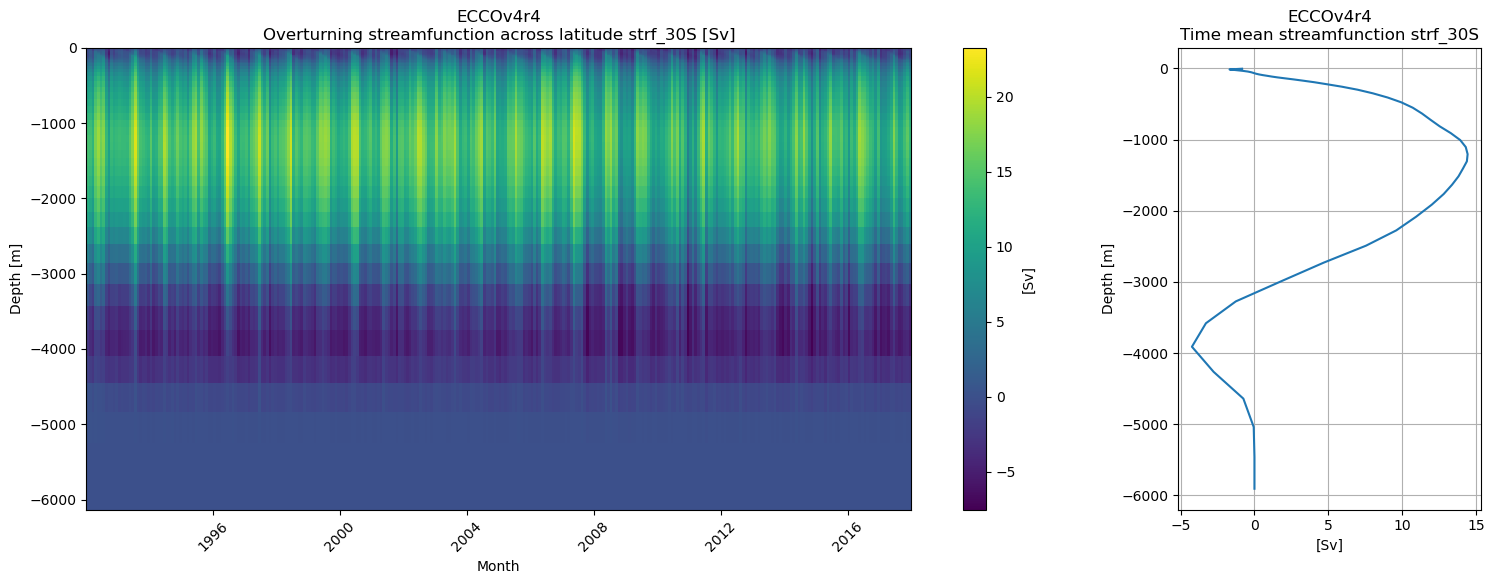

<xarray.DataArray 'moc' ()>
array(44)


In [12]:
# Retrieve the streamfunction in depth space
strf_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"

strf = read_streamfunction(strf_path, inputs.time, invert_depths=True)
plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label=f"strf_{format_lat_lon(lat)}", param='moc')

# Calculate the abyssal cell on the streamfunction -- compare the level
strf_comparison = strf.copy(deep=True)
# Avoid taking a min/max in the higher layers
strf_comparison['moc'].loc[dict(k=slice(0,5))] = 0
simulation_ecco_drive = get_PSI_at_max_density_level(strf_comparison.squeeze(), moc_param='moc', max=False)

In [13]:
# Retrieve the actual moc strength in depth space from ecco (ggdrive)
moc_depth_ecco = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_moc_depth.pickle"
moc_ecco = read_moc_strength_dataset(moc_depth_ecco, inputs.time)

# Find the depths that align with the given moc strength (in streamfunction)
difference = abs(strf - moc_ecco.broadcast_like(strf))
min_diff_index = difference.argmin(dim='k')
closest_depths = strf_comparison.Z.isel(k=min_diff_index.moc.values)
closest_depths = closest_depths.rename({'k': 'time'})

In [14]:
# Retrieve the streamfunction as calculated with ACCESS data
moc_access = f"{data_home}/access_data/MOC_30S_at.nc"

moc_access = xr.open_dataset(moc_access)
moc_access = moc_access.rename({'MOC': 'moc'})
for var_name in moc_access:
    moc_access[var_name] = moc_access[var_name] / 1e6

# Adjust the date range when working with ACCESS to the available ECCO data
date_range = (moc_ecco.time.values[0], moc_ecco.time.values[-1]) 
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
moc_ecco, moc_access = align_inputs_outputs(moc_ecco, moc_access, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


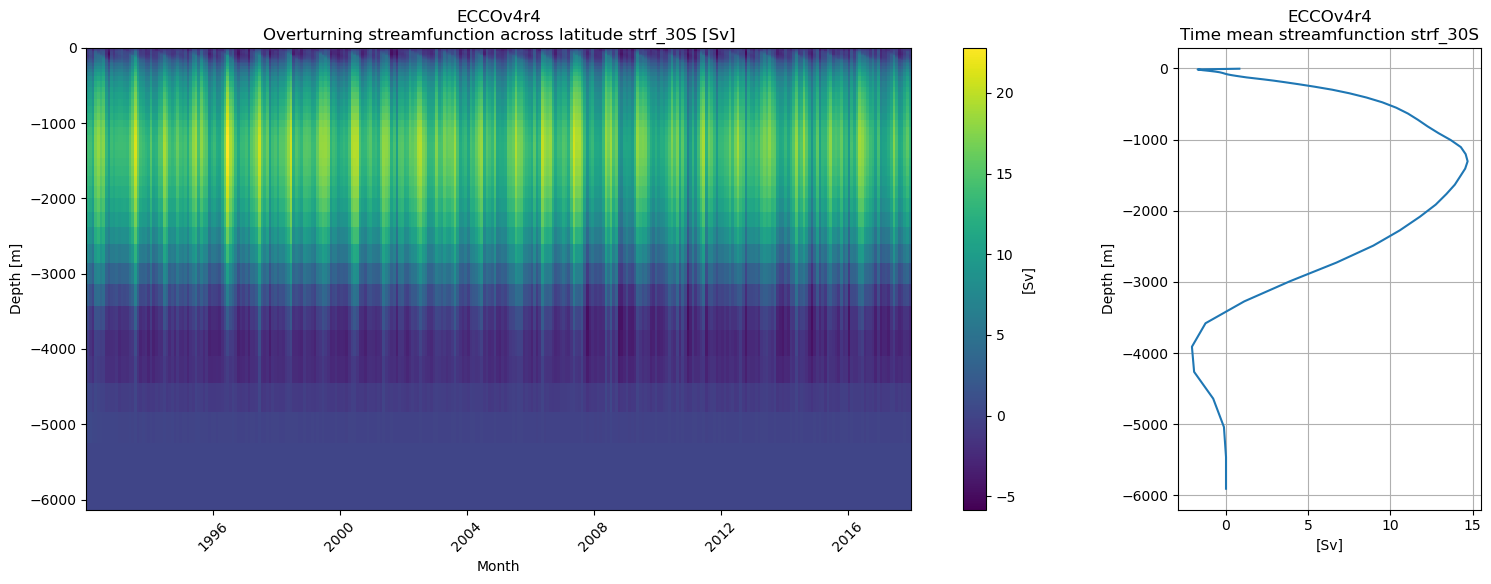

<xarray.DataArray 'psi_moc' ()>
array(44)
Coordinates:
    lat      int32 -30


In [15]:
lat = -30

# Retrieve the streamfunction as calculated in the native grid
OUTPUT_DIR = paths.STREAMFUNCTIONS_ECCO_OUTPUT
PSI_mean = xr.open_dataset(os.path.join(OUTPUT_DIR, f"{format_lat_lon(lat)}", f"PSI_atlantic_residual{format_lat_lon(lat)}.nc"))
PSI_bol = xr.open_dataset(os.path.join(OUTPUT_DIR, f"{format_lat_lon(lat)}", f"PSI_atlantic_bolus{format_lat_lon(lat)}.nc"))
strf_native_ecco = PSI_mean + PSI_bol

plot_depth_stf_vs_time(stf_ds=strf_native_ecco.squeeze(), label=f"strf_{format_lat_lon(lat)}", param='psi_moc')

# Deduce the MOC strength in the abyssal cel
strf_comparison = strf_native_ecco.copy(deep=True)
strf_comparison['psi_moc'].loc[dict(k=slice(0,5))] = 0
moc_native_ecco = get_PSI_at_max_density_level(strf_comparison.squeeze(), moc_param='psi_moc', max=False)

In [16]:
moc_native_ecco = moc_native_ecco-2

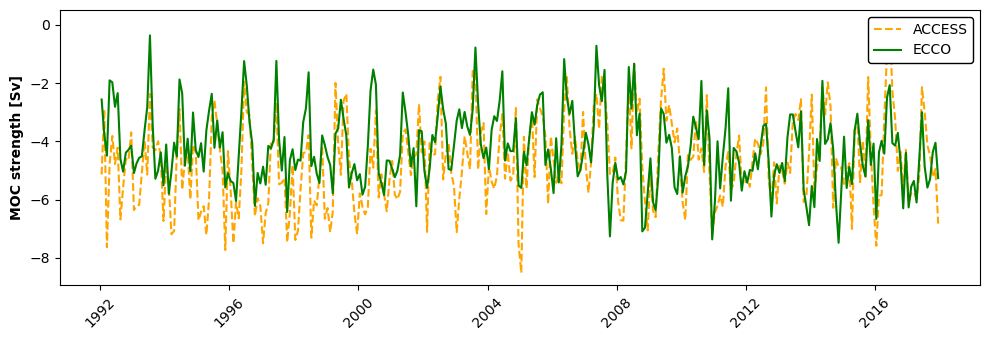

In [43]:
# Plot the desired streamfunctions together
plt.figure(figsize = (10, 3.5))

plt.plot(moc_access["time"].squeeze(), moc_access["moc"].squeeze(), label='ACCESS', color="orange", linestyle='--', linewidth=1.5)
plt.plot(simulation_ecco_drive["time"].squeeze(), simulation_ecco_drive["moc"].squeeze(), color="green", label='ECCO', linewidth=1.5)  
#plt.plot(moc_native_ecco["time"].squeeze(), moc_native_ecco["psi_moc"].squeeze(), color="orange", linestyle='-', label='ECCO native grid', linewidth=1.5) 

plt.xticks(rotation=45)
plt.ylabel('MOC strength [Sv]', weight="bold")
plt.legend(loc = 'upper right', edgecolor = 'black', framealpha = 1, fontsize=10)
plt.tight_layout()
#plt.savefig(f"C:/Users/aline/OTP/plots/latlon_vs_nativegrid.png", dpi=400)
plt.savefig(f"C:/Users/aline/OTP/plots/ecco_vs_access.png", dpi=400)